In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r"/Users/vatsal/Desktop/Face-Mask-Detection-master/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [8]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

[INFO] loading images...


In [9]:
print(len(data))

3833


In [10]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [13]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 3s 0us/step


In [15]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [16]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [18]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [20]:
# train the head of the network
print("[INFO] training head...")
H = model.fit( aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 98s 1s/step - loss: 0.4136 - accuracy: 0.8471 - val_loss: 0.1577 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 98s 1s/step - loss: 0.1505 - accuracy: 0.9621 - val_loss: 0.0842 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 102s 1s/step - loss: 0.1042 - accuracy: 0.9723 - val_loss: 0.0661 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 96s 1s/step - loss: 0.0795 - accuracy: 0.9839 - val_loss: 0.0638 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 87s 913ms/step - loss: 0.0674 - accuracy: 0.9835 - val_loss: 0.0521 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 77s 814ms/step - loss: 0.0566 - accuracy: 0.9832 - val_loss: 0.0471 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 77s 804ms/step - loss: 0.0481 - accuracy: 0.9875 - val_loss: 0.0434 - val_acc

In [21]:
model.save('/Users/vatsal/Desktop/Face-Mask-Detection-master/Mask-Detection.model', save_format="h5")

/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
data = []

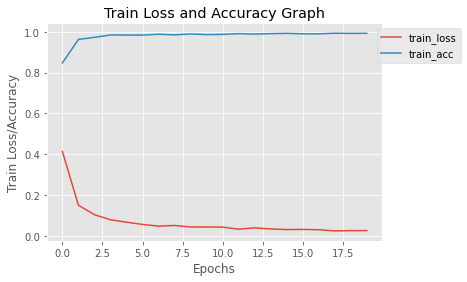

In [45]:
# loss/accuracy graph
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n), H.history["accuracy"], label="train_acc")
plt.title("Train Loss and Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Train Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot.png")

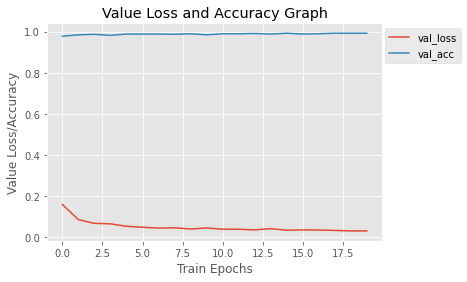

In [46]:
# value loss/accuracy graph
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n), H.history["val_accuracy"], label="val_acc")
plt.title("Value Loss and Accuracy Graph")
plt.xlabel("Train Epochs")
plt.ylabel("Value Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot1.png")

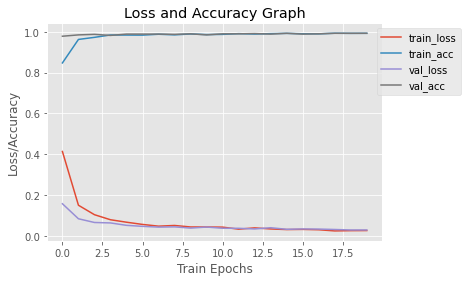

In [47]:
# value loss/accuracy graph
n = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, n), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n), H.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy Graph")
plt.xlabel("Train Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot2.png")

In [27]:
#to check train accuacy
modelTLoss, modelTAccuracy = model.evaluate(trainX, trainY)

print('Train Loss is: {}'.format(modelTLoss))
print('Train Accuracy is: {}'.format(modelTAccuracy ))

96/96 [==============================] - 73s 758ms/step - loss: 0.0177 - accuracy: 0.9948
Train Loss is: 0.01774311065673828
Train Accuracy is: 0.994781494140625


In [28]:
modelTLoss = []

In [29]:
modelTAccuracy = []

In [31]:
#to check test accuacy
modelLoss, modelAccuracy = model.evaluate(testX, testY)

print('Test Loss is: {}'.format(modelLoss))
print('Test Accuracy is: {}'.format(modelAccuracy ))

24/24 [==============================] - 18s 742ms/step - loss: 0.0294 - accuracy: 0.9922
Test Loss is: 0.029390018433332443
Test Accuracy is: 0.9921773076057434


In [32]:
modelLoss = []

In [33]:
modelAccuracy = []

In [37]:
# classification report on train
predIdxs = model.predict (trainX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=lb.classes_, digits = 3))

              precision    recall  f1-score   support

   with_mask      0.993     0.997     0.995      1532
without_mask      0.997     0.993     0.995      1534

    accuracy                          0.995      3066
   macro avg      0.995     0.995     0.995      3066
weighted avg      0.995     0.995     0.995      3066



In [38]:
# classification report on test
predIdxs = model.predict (testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_, digits = 3))

              precision    recall  f1-score   support

   with_mask      0.992     0.992     0.992       383
without_mask      0.992     0.992     0.992       384

    accuracy                          0.992       767
   macro avg      0.992     0.992     0.992       767
weighted avg      0.992     0.992     0.992       767



In [39]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusionmatrix = confusion_matrix(testY.argmax(axis=1), predIdxs)
print(confusionmatrix)

[[380   3]
 [  3 381]]


In [43]:
import pandas as pd
import seaborn as sns

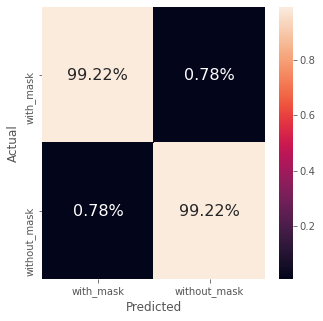

In [44]:
# heatmap
df_cm= pd.DataFrame(confusionmatrix, columns=lb.classes_, index=lb.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
plt.show()